### Install Dependencies

In [0]:
%pip install mlflow
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install numpy

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2f08c9ab-f3fa-473e-aae6-59e898d5e8e1
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Not uninstalling requests at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2f08c9ab-f3fa-473e-aae6-59e898d5e8e1
    Can't uninstall 'requests'. No files were found to uninstall.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-2f08c9ab-f3fa-473e-aae6-59e898d5e8e

### Import Dependencies and log experiment

In [0]:

import mlflow
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# set the experiment id
mlflow.set_experiment(experiment_id="469548299237702")

mlflow.autolog()

2025/01/14 10:01:36 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2025/01/14 10:01:36 INFO mlflow.spark.autologging: Autologging successfully enabled for spark.
2025/01/14 10:01:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2025/01/14 10:01:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


Out[1]: <ActiveRun: >

### Download data

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualize Data

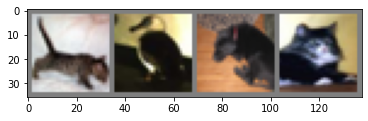

cat   bird  dog   cat  


In [0]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Create Neural Network

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Train Network

In [0]:
# Define the model, criterion, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Start an MLflow run
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("lr", 0.001)
    mlflow.log_param("momentum", 0.9)
    mlflow.log_param("epochs", 2)

    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accumulate loss
            running_loss += loss.item()
            if i % 2000 == 1999:    # log every 2000 mini-batches
                avg_loss = running_loss / 2000
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                mlflow.log_metric("loss", avg_loss, step=epoch * len(trainloader) + i)
                running_loss = 0.0

    # Log the model
    mlflow.pytorch.log_model(net, "model")

print('Finished Training')

🏃 View run likeable-mouse-994 at: https://community.cloud.databricks.com/ml/experiments/469548299237702/runs/70d8362581ea426c905a3e16022fdcd3
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/469548299237702
[1,  2000] loss: 2.228
[1,  4000] loss: 1.907
[1,  6000] loss: 1.724
[1,  8000] loss: 1.622
[1, 10000] loss: 1.549
[1, 12000] loss: 1.494
[2,  2000] loss: 1.438
[2,  4000] loss: 1.391
[2,  6000] loss: 1.373
[2,  8000] loss: 1.327
[2, 10000] loss: 1.308
[2, 12000] loss: 1.299


2025/01/14 10:05:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-35a64-16c52-78aef-0/tmpxi883t1r/model/data, flavor: pytorch). Fall back to return ['torch==2.5.1', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2025/01/14 10:05:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run tasteful-chimp-390 at: https://community.cloud.databricks.com/ml/experiments/469548299237702/runs/0b1cb3152cc94415a15944b16bbc38d8
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/469548299237702
Finished Training


### Save trained model 

In [0]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the model

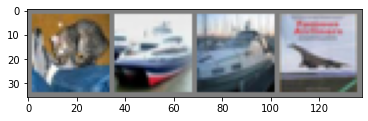

GroundTruth:  cat   ship  ship  plane


In [0]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))